$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib notebook
# import libraries
import os
import numpy as np
import os.path as path
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools
from pyccapt.calibration.calibration_tools import widgets as wd

In [2]:
# if recieve error for pytables library you should uncomment the line below and run the cell
import sys
# !conda install --yes --prefix {sys.prefix} pytables

In [3]:
# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3
# SS-420-1_data
# data_1029_Jun-27-2022_15-53_Pd

In [4]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$\text{Path to the dataset}$

In [5]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()
variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.join(p, 'tests/results/load_crop/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
# dataset name
filename = variables.path + '//' + dataset_name + '.h5'
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dldGroupStorage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model, pulse_mode=pulse_mode_ini)
dld_masterDataframe = data_loadcrop.concatenate_dataframes_of_dld_grp(dldGroupStorage)
print('Total number of Ions:', len(dldGroupStorage[0]))

Filename>> D:\pyccapt\tests//data//OLO_W_6_data.h5
{'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000188


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

<IPython.core.display.Javascript object>


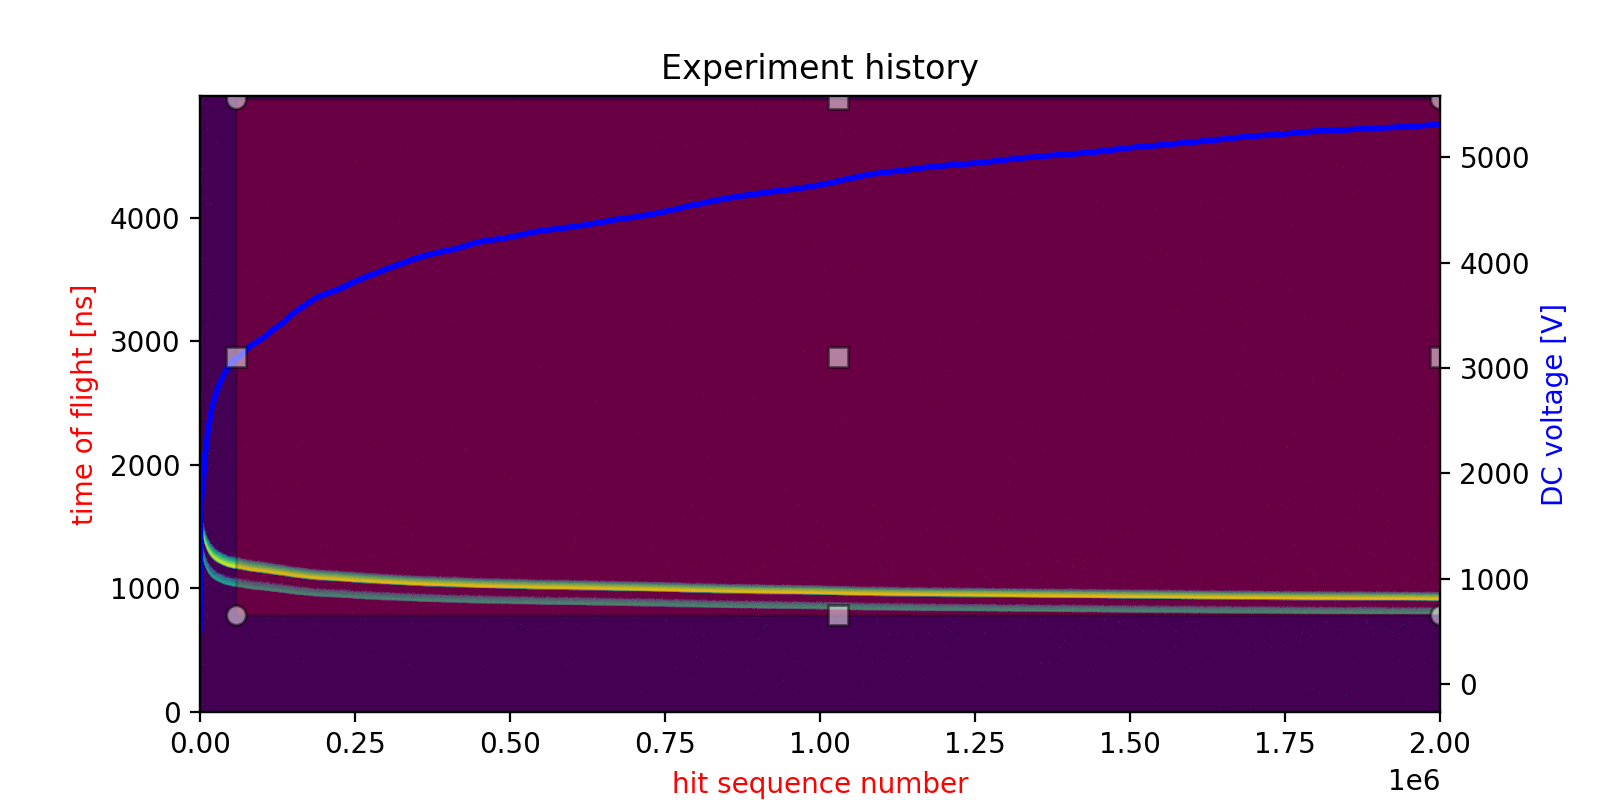

In [6]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, save_name = variables.result_path + '//ex_hist_' + dataset_name)



$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [7]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_masterDataframe)

Min Idx: 57943.92531502026 Max Idx: 2000060.9801537297


<IPython.core.display.Javascript object>


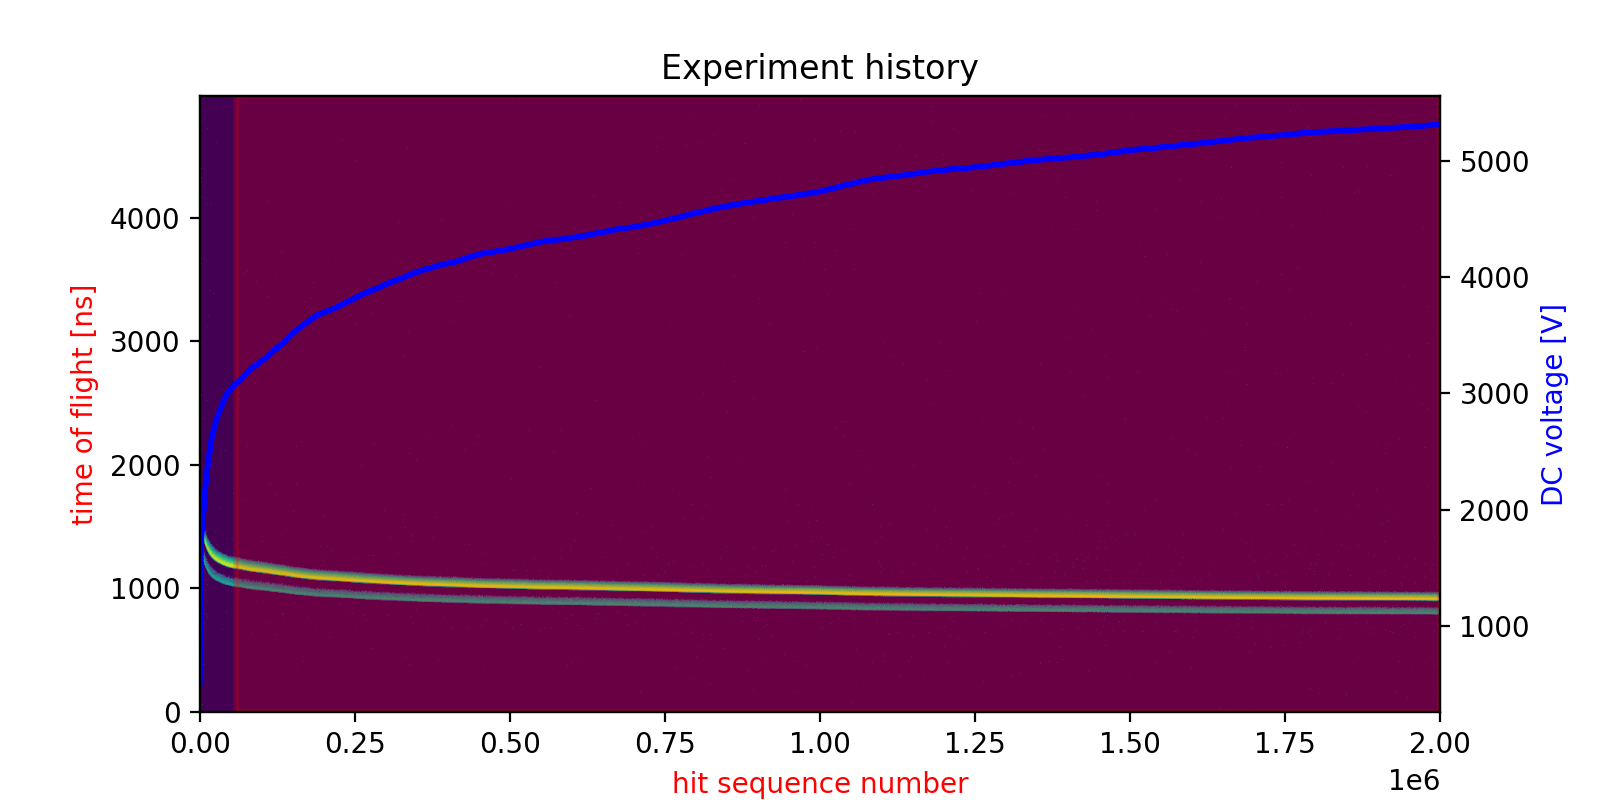

In [8]:
# Plot and selected experiment history
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

<IPython.core.display.Javascript object>


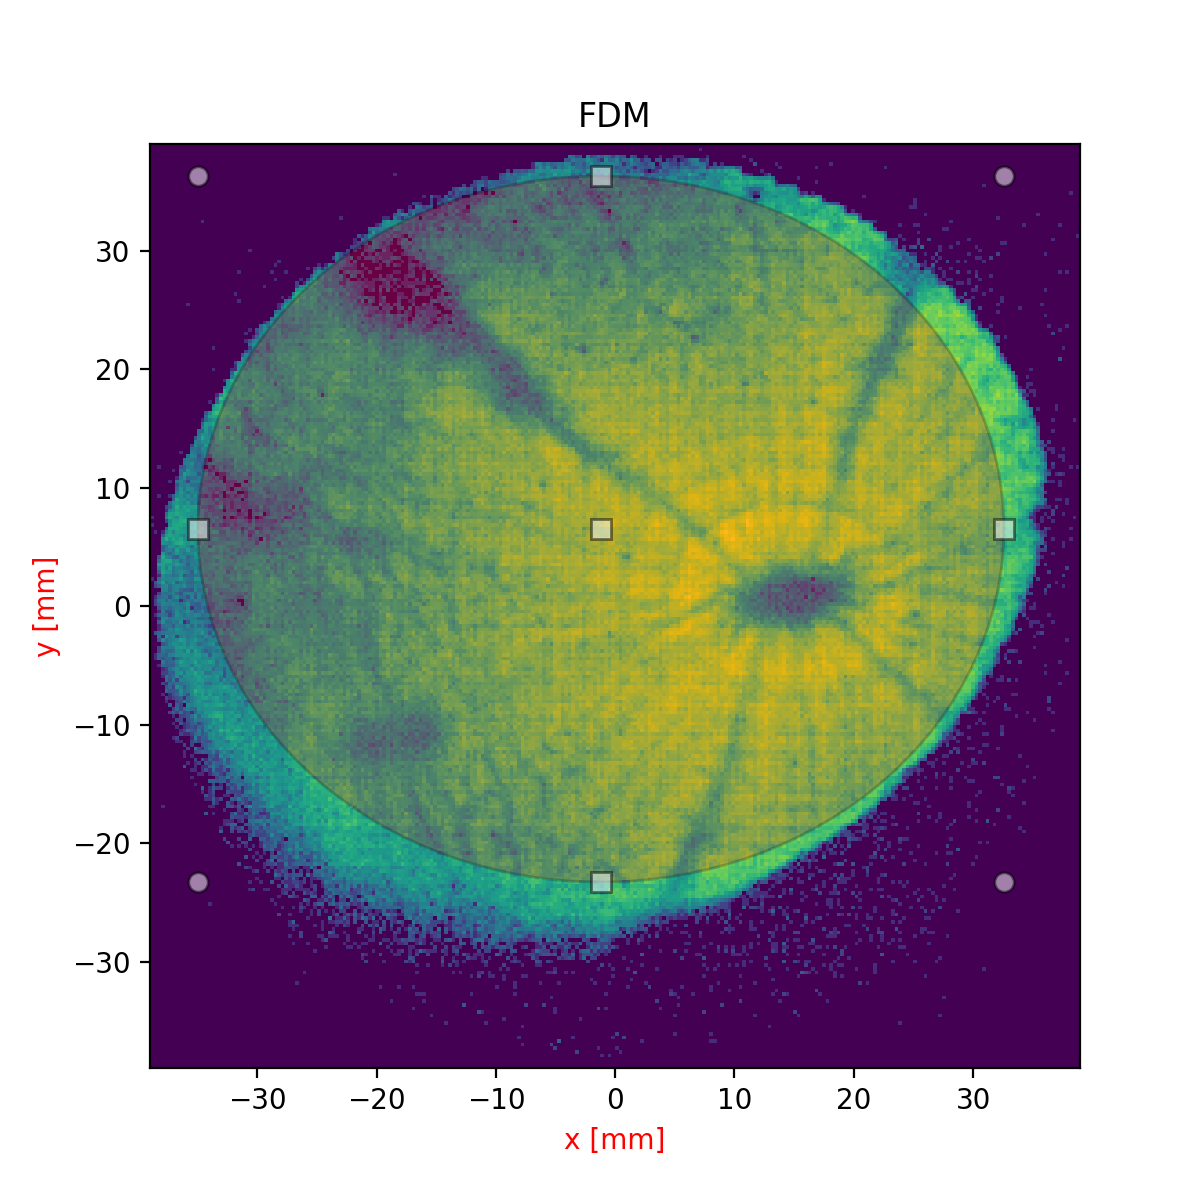

11-08-2022 11:54:21 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_OLO_W_6_data
11-08-2022 11:54:21 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_OLO_W_6_data
11-08-2022 11:54:21 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_OLO_W_6_data


In [9]:
# Plot and select the FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_crop_FDM(ax1, fig1, data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

<IPython.core.display.Javascript object>


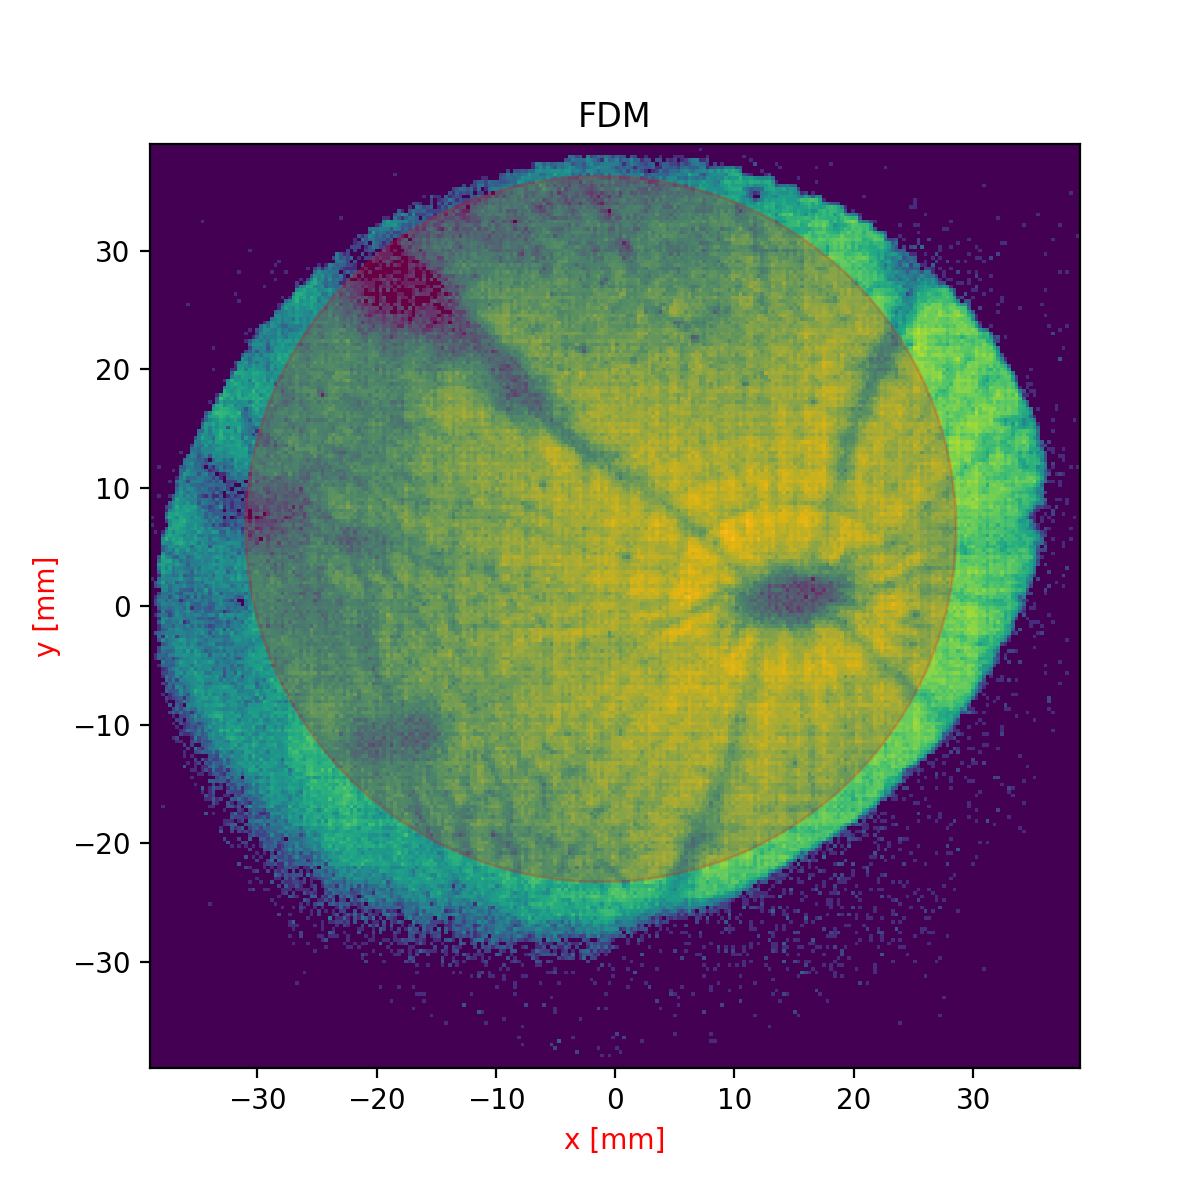

11-08-2022 11:55:08 | INFO | Circle selector Called
11-08-2022 11:55:08 | INFO | Circle selector Called
11-08-2022 11:55:08 | INFO | Circle selector Called
x: -1.1961823979591912 y: 6.506673030413463 roi: 29.78653856347734
11-08-2022 11:55:08 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_c_OLO_W_6_data
11-08-2022 11:55:08 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_c_OLO_W_6_data
11-08-2022 11:55:08 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_c_OLO_W_6_data


In [11]:
# plot selected area in FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_FDM_after_selection(ax1, fig1, data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name)

$\text {The final selected data after processing is shown below.}$

<IPython.core.display.Javascript object>


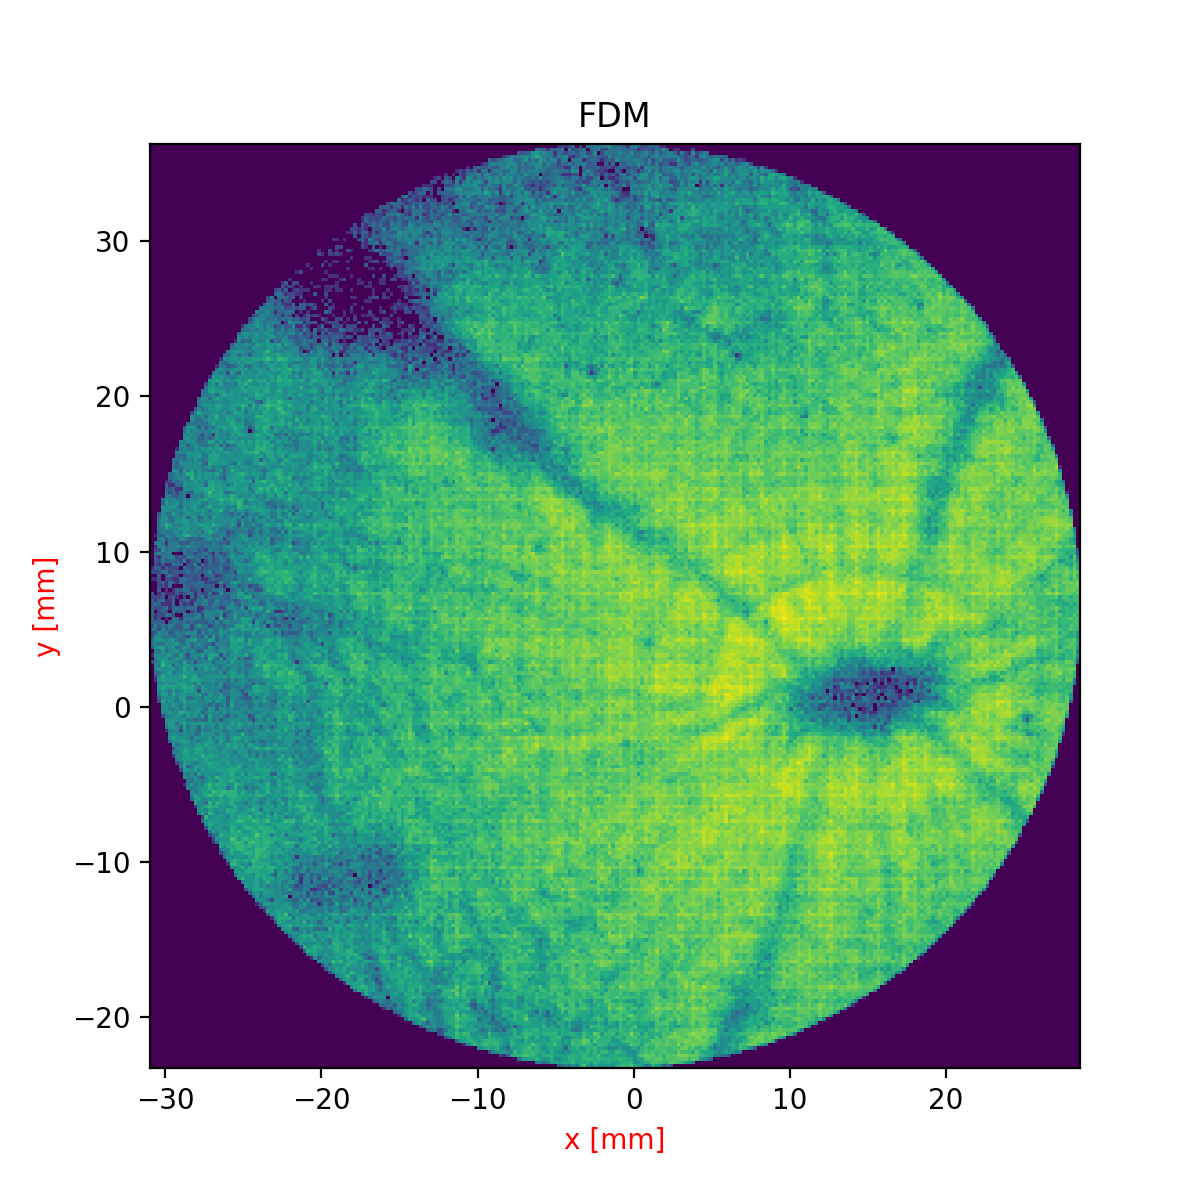

11-08-2022 11:55:16 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_crop_OLO_W_6_data
11-08-2022 11:55:16 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_crop_OLO_W_6_data
11-08-2022 11:55:16 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/OLO_W_6_data//FDM_crop_OLO_W_6_data


In [12]:
# Crop and plot the dataset
fig1, ax1 = plt.subplots(figsize=(6,6))
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_FDM(ax1, fig1, data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name)

In [13]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM[:, 2]

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped data sets
data_crop_FDM = np.append(data_crop_FDM, np.expand_dims(pulse_pi, axis=1), axis=1)
data_crop_FDM = np.append(data_crop_FDM, np.expand_dims(ion_pp, axis=1), axis=1)

$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [14]:
# save the dataset to hdf5 file
name = os.path.splitext(filename)[0]
data_loadcrop.save_croppped_data_to_hdf5(data_crop_FDM, dld_masterDataframe, savename, tdc_model, pulser_mode=pulse_mode_ini)

11-08-2022 11:55:20 | INFO | tofCropLossPct 18
11-08-2022 11:55:20 | INFO | tofCropLossPct 18
11-08-2022 11:55:20 | INFO | tofCropLossPct 18
tofCropLossPct 18
